In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Lattice
from pymatgen.core import Structure
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.analysis.structure_matcher import StructureMatcher
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve, ShuffleSplit

In [2]:
nn = CrystalNN() 
s_match = StructureMatcher()
scaler = StandardScaler()

# Read CSV file

In [3]:
df = pd.read_csv('vacancy_formation_energy.csv', index_col=0)

In [4]:
# the 'initial_structure' is the local enviroment (nearest neighbor) of the carbon vacancy from defective SQS supercell
# to facilate structural analysis, the Carbon atom at the center is still kept, i.e. it is easier to use pymatgen
# when there is 'something' at the vacnacy site
# the 'formula' is compositoin of the local eniveriment
df

,sqs_num,vac_num,initial_structure,formula,formation_energy
0,0,0,# generated using pymatgen\ndata_Hf3TaNb2C\n_s...,Hf3 Ta1 Nb2,0.829557
1,0,1,# generated using pymatgen\ndata_Hf2Zr2Ta2C\n_...,Hf2 Zr2 Ta2,0.753767
2,0,2,# generated using pymatgen\ndata_HfZr2TaNb2C\n...,Hf1 Zr2 Ta1 Nb2,0.685054
3,0,3,# generated using pymatgen\ndata_HfZr3Nb2C\n_s...,Hf1 Zr3 Nb2,0.642842
4,0,4,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.720223
...,...,...,...,...,...
1275,39,27,# generated using pymatgen\ndata_Hf2Zr3NbC\n_s...,Hf2 Zr3 Nb1,0.616234
1276,39,28,# generated using pymatgen\ndata_Hf2ZrTa3C\n_s...,Hf2 Zr1 Ta3,0.752099
1277,39,29,# generated using pymatgen\ndata_Zr2Ta2Nb2C\n_...,Zr2 Ta2 Nb2,0.477369
1278,39,30,# generated using pymatgen\ndata_HfZrTa2Nb2C\n...,Hf1 Zr1 Ta2 Nb2,0.577123


# Figure 2: visualization of data

## Figure 2a - Dependence on SQS supercells

Text(0.5, 1.0, 'Dependence on SQS supercells ')

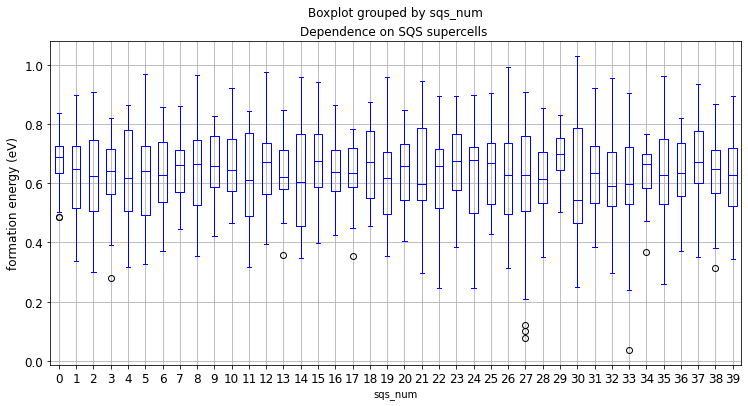

In [5]:
#plt.figure(figsize=(17, 10))
df.boxplot('formation_energy',by='sqs_num',color='b',figsize=(12,6), fontsize=12)
plt.ylabel('formation energy (eV)',fontsize = 12)
plt.title('Dependence on SQS supercells ',fontsize = 12)


## Figure 2b - Dependence on composition

Text(0.5, 1.0, 'Dependence on composition ')

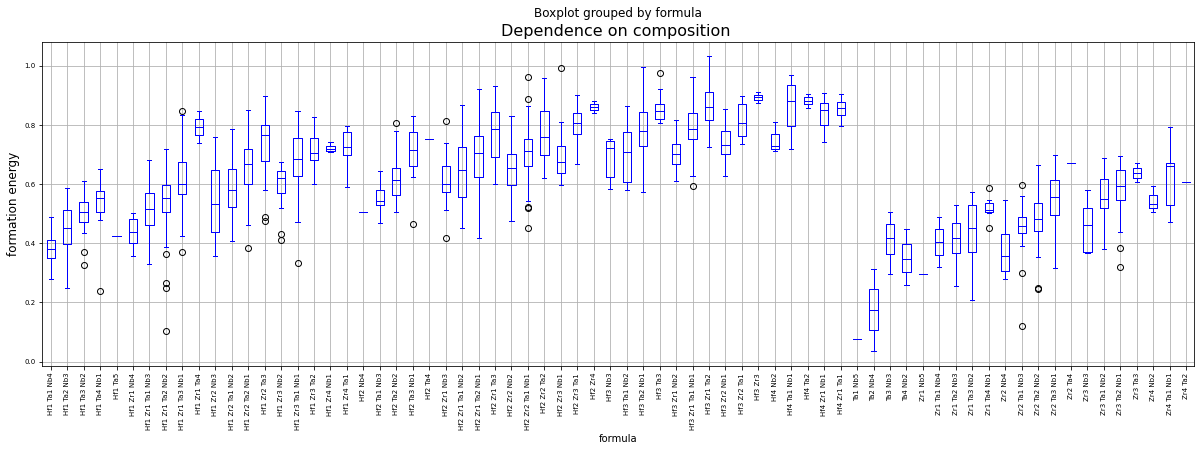

In [6]:
df.boxplot('formation_energy',by='formula',color='b', rot=90, figsize=(20,6), fontsize=7) 
plt.ylabel("formation energy", fontdict={'size': 12})
plt.title('Dependence on composition ',fontsize = 16)


## Figure 2c - depend on configuration

In [7]:
# add an empty column to store the label of unique structues
df['uniq_num'] = np.nan

s_match = StructureMatcher()
n2 = 0
xlabel = []
for formula in sorted(df['formula'].unique()):
    # first create a subset of dataframe, where all structrues have the same formula
    df_uniq = df.loc[df['formula'] == formula] 
    
    # generate a structure list, note the structrues are acutally local envierments
    structs = []
    for cif in df_uniq['initial_structure']:
        structs.append(Structure.from_str(cif, fmt='cif'))
        
    n1 = 0
    for i, struct_1 in enumerate(structs):
        idx1 = df_uniq.index[i]
        if pd.isna(df_uniq['uniq_num'][idx1]):
            n1 += 1
            df_uniq.loc[idx1, 'uniq_num'] = int(n1)
            df.loc[idx1, 'uniq_num'] = int(n1 + n2)
            for j, struct_2 in enumerate(structs):
                if j > i:
                    idx2 = df_uniq.index[j]
                    if s_match.fit(struct_1, struct_2):
                        df_uniq.loc[idx2, 'uniq_num'] = int(n1)
                        df.loc[idx2, 'uniq_num'] = int(n1 + n2)
                        
    n2 = n2 + n1

In [8]:
df

,sqs_num,vac_num,initial_structure,formula,formation_energy,uniq_num
0,0,0,# generated using pymatgen\ndata_Hf3TaNb2C\n_s...,Hf3 Ta1 Nb2,0.829557,105.0
1,0,1,# generated using pymatgen\ndata_Hf2Zr2Ta2C\n_...,Hf2 Zr2 Ta2,0.753767,92.0
2,0,2,# generated using pymatgen\ndata_HfZr2TaNb2C\n...,Hf1 Zr2 Ta1 Nb2,0.685054,28.0
3,0,3,# generated using pymatgen\ndata_HfZr3Nb2C\n_s...,Hf1 Zr3 Nb2,0.642842,42.0
4,0,4,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.720223,65.0
...,...,...,...,...,...,...
1275,39,27,# generated using pymatgen\ndata_Hf2Zr3NbC\n_s...,Hf2 Zr3 Nb1,0.616234,98.0
1276,39,28,# generated using pymatgen\ndata_Hf2ZrTa3C\n_s...,Hf2 Zr1 Ta3,0.752099,80.0
1277,39,29,# generated using pymatgen\ndata_Zr2Ta2Nb2C\n_...,Zr2 Ta2 Nb2,0.477369,150.0
1278,39,30,# generated using pymatgen\ndata_HfZrTa2Nb2C\n...,Hf1 Zr1 Ta2 Nb2,0.577123,15.0


In [17]:
df_local = df.copy()
formulas = []
uniq_nums = []
for idx in range(1280):
    if df_local.loc[idx, 'formula'] in formulas and df_local.loc[idx, 'uniq_num'] not in uniq_nums:
        df_local.loc[idx, 'formula'] = ''
    else:
        formulas.append(df_local.loc[idx, 'formula'])
        uniq_nums.append(df_local.loc[idx, 'uniq_num'])

In [18]:
df_local

,sqs_num,vac_num,initial_structure,formula,formation_energy,uniq_num
0,0,0,# generated using pymatgen\ndata_Hf3TaNb2C\n_s...,Hf3 Ta1 Nb2,0.829557,105.0
1,0,1,# generated using pymatgen\ndata_Hf2Zr2Ta2C\n_...,Hf2 Zr2 Ta2,0.753767,92.0
2,0,2,# generated using pymatgen\ndata_HfZr2TaNb2C\n...,Hf1 Zr2 Ta1 Nb2,0.685054,28.0
3,0,3,# generated using pymatgen\ndata_HfZr3Nb2C\n_s...,Hf1 Zr3 Nb2,0.642842,42.0
4,0,4,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.720223,65.0
...,...,...,...,...,...,...
1275,39,27,# generated using pymatgen\ndata_Hf2Zr3NbC\n_s...,,0.616234,98.0
1276,39,28,# generated using pymatgen\ndata_Hf2ZrTa3C\n_s...,Hf2 Zr1 Ta3,0.752099,80.0
1277,39,29,# generated using pymatgen\ndata_Zr2Ta2Nb2C\n_...,Zr2 Ta2 Nb2,0.477369,150.0
1278,39,30,# generated using pymatgen\ndata_HfZrTa2Nb2C\n...,,0.577123,15.0


In [19]:
df_local.loc[df_local['formula'] == 'Hf2 Zr1 Nb3']

,sqs_num,vac_num,initial_structure,formula,formation_energy,uniq_num
4,0,4,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.720223,65.0
201,6,9,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.723408,65.0
234,7,10,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.602936,65.0
252,7,28,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.629083,65.0
502,15,22,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.734411,65.0
517,16,5,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.662177,65.0
554,17,10,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.588552,65.0
596,18,20,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.557961,65.0
611,19,3,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.590174,65.0
621,19,13,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.622299,65.0


In [16]:
df.loc[df['formula'] == 'Hf2 Zr1 Nb3']

,sqs_num,vac_num,initial_structure,formula,formation_energy,uniq_num
4,0,4,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.720223,65.0
195,6,3,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.540157,66.0
201,6,9,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.723408,65.0
234,7,10,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.602936,65.0
252,7,28,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.629083,65.0
268,8,12,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.512301,66.0
369,11,17,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.416335,67.0
473,14,25,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.597890,66.0
502,15,22,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.734411,65.0
517,16,5,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.662177,65.0


Text(0.5, 1.0, 'Dependence on configuration ')

<Figure size 3000x2000 with 0 Axes>

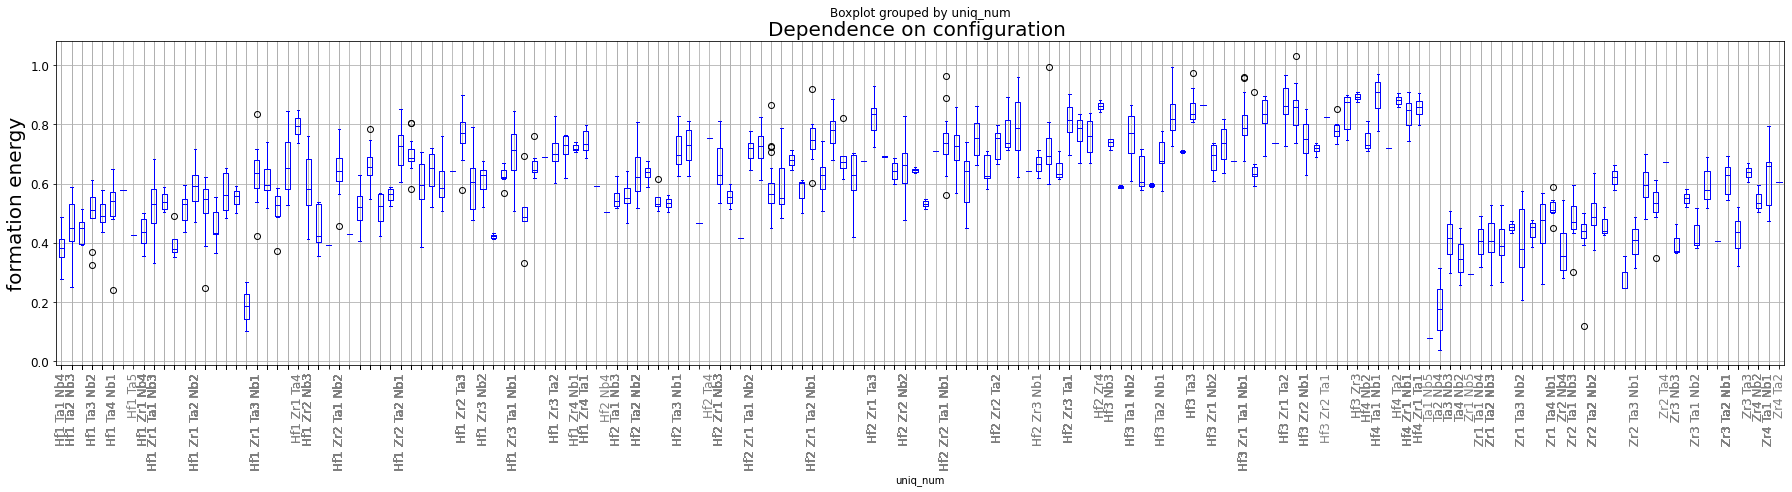

In [20]:
plt.figure(dpi=500)
df_local.boxplot('formation_energy', by='uniq_num', color='b', figsize=(30,6), fontsize=12, rot=90,)
plt.ylabel("formation energy", fontdict={'size': 20})
plt.xticks(ticks=df_local['uniq_num'], labels=df_local['formula'], color='grey', rotation=90) # 
plt.title('Dependence on configuration ',fontsize = 20)

# Figure 4: Random Forest Model

## Input features: idea from RDF

### First read the SQSs without carbon vacancy in vasp format

In [92]:
os.chdir('sqs')

In [93]:
vasp_list=os.listdir()
vasp_list.sort(key = lambda x:int(x[:-5]))  #顺序排列文件
print(vasp_list)

['1.vasp', '2.vasp', '3.vasp', '4.vasp', '5.vasp', '6.vasp', '7.vasp', '8.vasp', '9.vasp', '10.vasp', '11.vasp', '12.vasp', '13.vasp', '14.vasp', '15.vasp', '16.vasp', '17.vasp', '18.vasp', '19.vasp', '20.vasp', '21.vasp', '22.vasp', '23.vasp', '24.vasp', '25.vasp', '26.vasp', '27.vasp', '28.vasp', '29.vasp', '30.vasp', '31.vasp', '32.vasp', '33.vasp', '34.vasp', '35.vasp', '36.vasp', '37.vasp', '38.vasp', '39.vasp', '40.vasp']


In [94]:
no_vac_structs = []
for f in vasp_list:
    no_vac_structs.append(Structure.from_file(f))

In [95]:
os.chdir('../')

### Generate features using 1st, 3rd, 5th neighbor atoms

In [96]:
# the folowing values are radius of different atomic shells centered in a carbon vacancy
# note that the structure is unrelaxed, ideal structure
# although there should be no 'dr', due to some unknown reason of pymatgen, it is more accurate to spefic a 'dr' value
r1 = 2.7
r3 = 5
r5 = 6.8
r7 = 9.2
dr = 0.5
dr2 = 0.3

elem_list = ['Hf', 'Zr', 'Ta', 'Nb']

In [97]:
i = 0
for s in no_vac_structs:
    for j in range(32,64): # number of atoms is 64
        feature = []
        
        idx = []
        for n in s.get_neighbors_in_shell(s[j].coords, r1, dr):
            idx.append(n.specie.symbol)
        for elem in elem_list:
            feature.append(idx.count(elem))
        df.loc[i, 'nearest_neighbor'] = ' '.join(map(str,feature)) ##nearest_neighbor
         
        idx = []
        for n in s.get_neighbors_in_shell(s[j].coords, r3, dr):
            idx.append(n.specie.symbol)
        for elem in elem_list:
            feature.append(idx.count(elem))        
        df.loc[i, '3rd_neighbor'] = ' '.join(map(str,feature)) ## 3rd_nearest_neighbor
        
        idx = []
        for n in s.get_neighbors_in_shell(s[j].coords, r5, dr):
            idx.append(n.specie.symbol)
        for elem in elem_list:
            feature.append(idx.count(elem)) 
        df.loc[i, '5th_neighbor'] = ' '.join(map(str,feature)) ## 5th_nearest_neighbor
        
        idx = []
        for n in s.get_neighbors_in_shell(s[j].coords, r7, dr2):
            idx.append(n.specie.symbol)
        for elem in elem_list:
            feature.append(idx.count(elem)) 
        df.loc[i, '7th_neighbor'] = ' '.join(map(str,feature))  ## 第九近邻
        
        i += 1

In [98]:
df # now the dataframe has features in the last few columns

,sqs_num,vac_num,initial_structure,formula,formation_energy,uniq_num,nearest_neighbor,3rd_neighbor,5th_neighbor,7th_neighbor
0,0,0,# generated using pymatgen\ndata_Hf3TaNb2C\n_s...,Hf3 Ta1 Nb2,0.829557,105.0,3 0 1 2,3 0 1 2 1 2 4 1,3 0 1 2 1 2 4 1 4 10 4 6,3 0 1 2 1 2 4 1 4 10 4 6 11 4 5 10
1,0,1,# generated using pymatgen\ndata_Hf2Zr2Ta2C\n_...,Hf2 Zr2 Ta2,0.753767,92.0,2 2 2 0,2 2 2 0 1 2 4 1,2 2 2 0 1 2 4 1 6 6 2 10,2 2 2 0 1 2 4 1 6 6 2 10 10 6 6 8
2,0,2,# generated using pymatgen\ndata_HfZr2TaNb2C\n...,Hf1 Zr2 Ta1 Nb2,0.685054,28.0,1 2 1 2,1 2 1 2 1 2 4 1,1 2 1 2 1 2 4 1 10 4 2 8,1 2 1 2 1 2 4 1 10 4 2 8 5 10 9 6
3,0,3,# generated using pymatgen\ndata_HfZr3Nb2C\n_s...,Hf1 Zr3 Nb2,0.642842,42.0,1 3 0 2,1 3 0 2 1 2 4 1,1 3 0 2 1 2 4 1 8 4 8 4,1 3 0 2 1 2 4 1 8 4 8 4 9 7 0 14
4,0,4,# generated using pymatgen\ndata_Hf2ZrNb3C\n_s...,Hf2 Zr1 Nb3,0.720223,65.0,2 1 0 3,2 1 0 3 1 2 4 1,2 1 0 3 1 2 4 1 8 4 8 4,2 1 0 3 1 2 4 1 8 4 8 4 6 13 0 11
...,...,...,...,...,...,...,...,...,...,...
1275,39,27,# generated using pymatgen\ndata_Hf2Zr3NbC\n_s...,Hf2 Zr3 Nb1,0.616234,98.0,2 3 0 1,2 3 0 1 2 2 2 2,2 3 0 1 2 2 2 2 4 4 6 10,2 3 0 1 2 2 2 2 4 4 6 10 10 7 12 1
1276,39,28,# generated using pymatgen\ndata_Hf2ZrTa3C\n_s...,Hf2 Zr1 Ta3,0.752099,80.0,2 1 3 0,2 1 3 0 2 2 2 2,2 1 3 0 2 2 2 2 4 4 6 10,2 1 3 0 2 2 2 2 4 4 6 10 10 13 3 4
1277,39,29,# generated using pymatgen\ndata_Zr2Ta2Nb2C\n_...,Zr2 Ta2 Nb2,0.477369,150.0,0 2 2 2,0 2 2 2 2 2 2 2,0 2 2 2 2 2 2 2 8 4 6 6,0 2 2 2 2 2 2 2 8 4 6 6 8 10 6 6
1278,39,30,# generated using pymatgen\ndata_HfZrTa2Nb2C\n...,Hf1 Zr1 Ta2 Nb2,0.577123,15.0,1 1 2 2,1 1 2 2 2 2 2 2,1 1 2 2 2 2 2 2 8 6 6 4,1 1 2 2 2 2 2 2 8 6 6 4 5 9 6 10


### using different input feature sets

In [99]:
def standardization(x):
    scaler = StandardScaler()
    scaler.fit(x)
    X = scaler.transform(x)
    return X

In [100]:
## random forest & compute cross validation scores for random forest model#  

def rf_cross_validation(x,y):
        #Try a random forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=1)
    rf.fit(x, y)

    print('training R2 = ' + str(round(rf.score(x, y), 3)))
    print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=rf.predict(x))))
    print('training MAE = %.3f' % mean_absolute_error(y_true=y, y_pred=rf.predict(x)))
    
    crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
    r2_scores = cross_val_score(rf, x, y, scoring='r2', cv=crossvalidation, n_jobs=-1)
    mae_scores = cross_val_score(rf, x, y, scoring='neg_mean_absolute_error', cv=crossvalidation, n_jobs=-1)
    scores = cross_val_score(rf, x, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)
    rmse_scores = [np.sqrt(abs(s)) for s in scores]

    print('Cross-validation results:')
    print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
    print('Folds: %i, mean MAE: %.3f' % (len(scores), np.mean(np.abs(mae_scores))))
    print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

#### nearest_neighbor feature

In [101]:
x1 = pd.DataFrame(columns=range(4))

for idx, row in df.iterrows():
    x1.loc[len(x1)] = list(map(int, row['nearest_neighbor'].split()))

X1 = standardization(x1)

y = df['formation_energy'].values
rf_cross_validation(X1, y)

training R2 = 0.635
training RMSE = 0.088
training MAE = 0.068
Cross-validation results:
Folds: 10, mean R2: 0.587
Folds: 10, mean MAE: 0.072
Folds: 10, mean RMSE: 0.093


#### 3rd_neighbor

In [102]:
x2 = pd.DataFrame(columns=range(8))

for idx, row in df.iterrows():
    x2.loc[len(x2)] = list(map(int, row['3rd_neighbor'].split()))

X2 = standardization(x2)

y = df['formation_energy'].values
rf_cross_validation(X2,y)

training R2 = 0.856
training RMSE = 0.055
training MAE = 0.041
Cross-validation results:
Folds: 10, mean R2: 0.641
Folds: 10, mean MAE: 0.067
Folds: 10, mean RMSE: 0.086


#### 5th_neighbor

In [103]:
x3 = pd.DataFrame(columns=range(12))

for idx, row in df.iterrows():
    x3.loc[len(x3)] = list(map(int, row['5th_neighbor'].split()))

X3 = standardization(x3)

y = df['formation_energy'].values
rf_cross_validation(X3,y)

training R2 = 0.963
training RMSE = 0.028
training MAE = 0.021
Cross-validation results:
Folds: 10, mean R2: 0.771
Folds: 10, mean MAE: 0.054
Folds: 10, mean RMSE: 0.069


## Figure 4a

In [106]:
def calc_learning_curve(X1, X2, X3, y):
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    estimator = RandomForestRegressor(n_estimators=100, random_state=1)
    
    ### train_scores for each input feature set
    train_sizes, train_scores, test_scores = learning_curve(
            estimator, X1, y,scoring='neg_mean_absolute_error', cv=cv, 
            train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean1 = np.mean(test_scores, axis=1)* -1
    
    train_sizes, train_scores, test_scores = learning_curve(
            estimator, X2, y, scoring='neg_mean_absolute_error', cv=cv, 
            train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean2 = np.mean(test_scores, axis=1)* -1

    test_sizes, train_scores, test_scores = learning_curve(
            estimator, X3, y, scoring='neg_mean_absolute_error', cv=cv, 
            train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
    test_scores_mean3 = np.mean(test_scores, axis=1)* -1
    
    
    # plot_learning_curve
    plt.figure(figsize=(6, 6))
#    plt.grid(linestyle='-',linewidth=1,alpha=0.8)   ## add grid lines
    plt.plot(train_sizes, test_scores_mean1, 'o-',linewidth=1.5, color="r", label="Nearest-neighbor") 
    plt.plot(train_sizes, test_scores_mean2, 'v-',linewidth=1.5, color="g", label="3rd_neighbor")
    plt.plot(train_sizes, test_scores_mean3, '*-',linewidth=1.5, color="orange", label="5th_neighbor")


    plt.legend(loc ="best", fontsize = 12)
    plt.tick_params(labelsize = 12) 
    plt.xlabel("Training examples",fontsize = 14)
    plt.ylabel("Mean Absolute Error(eV)",fontsize = 14)
    plt.tick_params(left='on',bottom='on',direction='in')


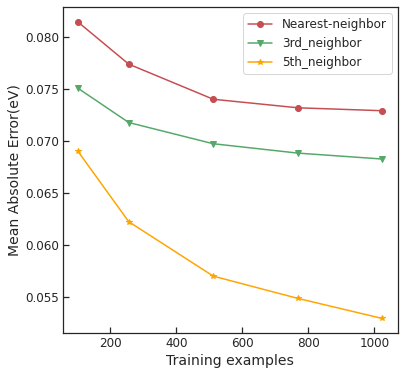

In [107]:
calc_learning_curve(X1, X2, X3, y)

## Figure 4b

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(x1, y)
feat_labels = elem_list
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x1.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

df_import = pd.DataFrame()
included = x1.columns.values
indices = np.argsort(importances)[::-1]

df_import["x1"]=included[indices][0:10]
df_import["y"]=importances[indices][0:10]
sns.set(style="whitegrid")
plt.figure(figsize=(6, 5))
ax = sns.barplot(x="x1", y="y",data = df_import,order =[0,3,1,2])
ax.set( xlabel ='' , ylabel = 'Importance (%)')

ax.set_xticklabels(['Hf', 'Zr', 'Ta', 'Nb'],size = 12)
ax.tick_params(left='on',bottom='on',direction='in')

In [109]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X3, y)
importances = rf.feature_importances_  

In [110]:
###### df_importance

df_import = pd.DataFrame()
included = x3.columns.values
indices = np.argsort(importances)[::-1]

df_import["x3"]=included[indices][0:12]
df_import["y"]=importances[indices][0:12]


elem = ['Hf', 'Nb', 'Zr','Ta','Hf', 'Nb', 'Zr','Ta','Hf', 'Nb', 'Zr','Ta']
near_neighbor = ['nearest_neighbor','nearest_neighbor',	'nearest_neighbor','nearest_neighbor','3rd_neighbor', '3rd_neighbor','3rd_neighbor','3rd_neighbor',	
                 '5th_neighbor','5th_neighbor','5th_neighbor', '5th_neighbor']
for n in range(12):
    df_import.loc[n,'element'] = ''.join(map(str,elem[n])) #
    df_import.loc[n,'near_neighbor'] = ''.join(map(str,near_neighbor[n]))

In [111]:
df_import

,x3,y,element,near_neighbor
0,0,0.316668,Hf,nearest_neighbor
1,3,0.272139,Nb,nearest_neighbor
2,11,0.088000,Zr,nearest_neighbor
3,7,0.058674,Ta,nearest_neighbor
4,8,0.057131,Hf,3rd_neighbor
5,1,0.033744,Nb,3rd_neighbor
6,10,0.031880,Zr,3rd_neighbor
7,4,0.031229,Ta,3rd_neighbor
8,9,0.030092,Hf,5th_neighbor
9,6,0.030021,Nb,5th_neighbor


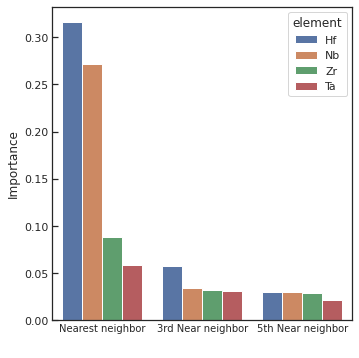

In [112]:
sns.set(style="ticks")

p = sns.catplot(x="near_neighbor",y="y", hue="element", kind='bar',data=df_import,legend_out=False) 

p.set( xlabel = " ", ylabel = 'Importance')
p.set_xticklabels(['Nearest neighbor', '3rd Near neighbor', '5th Near neighbor'],size = 10, rotation = 0)
p.despine(left=False, right=False, top =False)

plt.tick_params(left='on',bottom='on',direction='in') 


## Figure 4c and 4d

In [115]:
def calc_obs_vs_pred(X, y, estimator, test_size=0.2):
    '''
    The observation vs prediction plot
    '''
    df = pd.DataFrame(columns=['train_truth', 'train_predict', 'test_truth', 'test_predict'])
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=test_size, random_state=1)
    estimator.fit(X_train, y_train)
    
    df['train_truth'] = y_train
    df['train_predict'] = estimator.predict(X_train)
    df['test_truth'] = pd.Series(y_test)
    df['test_predict'] = pd.Series(estimator.predict(X_test))
    
    
    return df

In [113]:
def plot_obs_vs_pred(df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    sns.set(style="ticks",font_scale=1.5)
   
   ###### first figure
    #ax.text(-0.15, -0.1, '(a)', transform=ax.transAxes, size=16)
    
    axesSub = sns.scatterplot(x= 'train_predict', y='train_truth', s=200, marker='o',  data = df,alpha = 0.7, color = 'b',ax=axs[0])
    formatXy = 'y = x'
    axs[0].plot((0, 1.2),(0, 1.2), transform=axs[0].transAxes, linewidth=3, ls='--',c='k',alpha=0.6, label = formatXy)
    
    #######定义标签
    train_test = df['train_truth'].to_numpy()
    train_pred =  df['train_predict'].to_numpy()
    
    xy_mse = np.sum((train_pred-train_test)**2);
    xy_mean = np.mean(train_pred);
    xx_mean = np.sum((train_pred - xy_mean)**2);
    #R2 = 1 - xy_mse/xx_mean
    R = np.sqrt(1 - xy_mse/xx_mean)
    MAE = np.mean(np.abs(train_pred - train_test))
    RMSE = np.sqrt(np.mean((train_pred - train_test)**2))
    str_R1 = 'R = %.3f \nRMSE = %.3f \nMAE = %.3f '%(R, RMSE, MAE)
        
    axs[0].set_xlim(0,1.2)
    axs[0].set_ylim(0,1.2)
#    axs[0].tick_params(labelsize=14)
    
    ###### second figure
 
    axesSub = sns.scatterplot(x= 'test_predict', y='test_truth', s=200,marker='o',  data = df,alpha = 0.7, color = 'b',ax=axs[1])
    formatXy = 'y = x'
    axs[1].plot((0, 1.2),(0, 1.2), transform=axs[1].transAxes, linewidth=3, ls='--',c='k',alpha=0.6, label = formatXy)
#    axs[1].tick_params(labelsize=14)
    str_R2 = "R = 0.776 \nRMSE = 0.093 \nMAE = 0.072"  ### nearest neighbor
#    str_R2 = "R = 0.801 \nRMSE = 0.086 \nMAE = 0.069"  ### 3rd nearest neighbor
#    str_R2 = "R = 0.878 \nRMSE = 0.069 \nMAE = 0.054"  ### 5th nearest neighbor
    axs[0].set_xlim(0,1.2)
    axs[0].set_ylim(0,1.2)
    axs[0].set(xlabel='Train ground truth (eV)',
           ylabel='Prediction (eV)')
    axs[0].text(0,1,str_R1,fontsize = 14)
    axs[0].tick_params(left='on',bottom='on',direction='in')
    
    axs[1].set_xlim(0,1.2)
    axs[1].set_ylim(0,1.2)
    axs[1].set(xlabel='Test ground truth (eV)',
           ylabel='Prediction (eV)')
    axs[1].text(0,1,str_R2,fontsize = 14)
    axs[1].tick_params(left='on',bottom='on',direction='in')
    
    fig.subplots_adjust(wspace=0.2)
    
    
    return

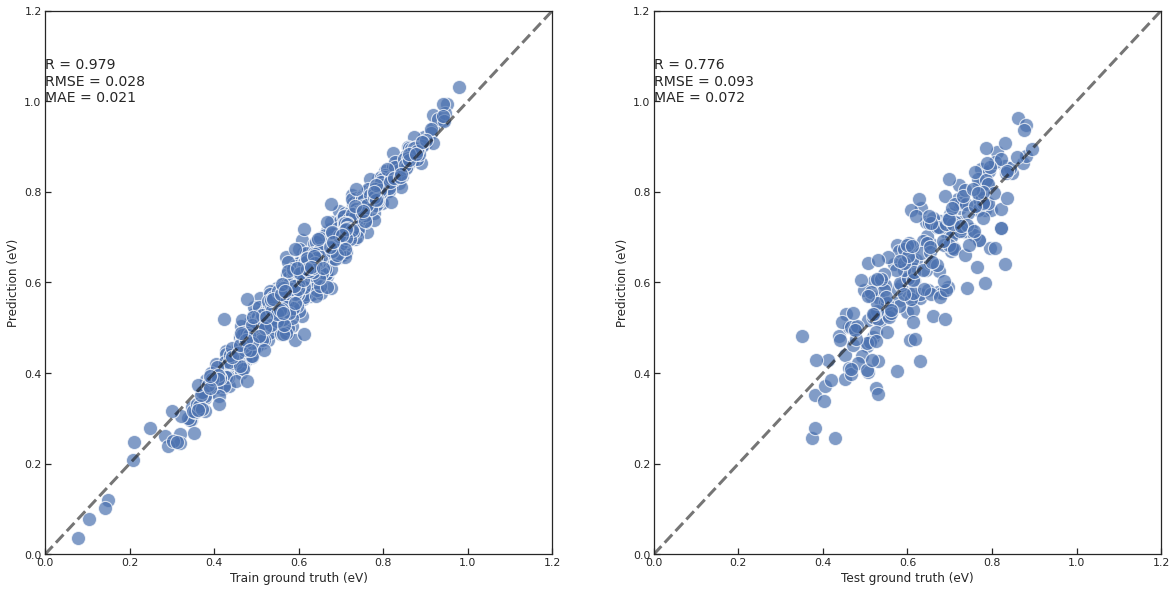

In [116]:
estimator = RandomForestRegressor(n_estimators=100, random_state=1)
df_ovp = calc_obs_vs_pred(X3, y, estimator=estimator)
plot_obs_vs_pred(df_ovp)